# Video Game Sales Forecasting Report

## Executive Summary

This is the analysis of the video game sales data with the goal of forecasting the next 4 months of sales to optimize inventory management.Analyzed historical sales patterns, identified key trends and seasonality factors, to guide in building forecasting models to predict future sales with high accuracy.

This analysis reveals that video game sales follow distinct seasonal patterns with peaks typically occurring during holiday seasons. There is an trend in sales over the analyzed period.

## Business Understanding
**Challenge**: The company needs to forecast demand accurately to avoid stockouts and overstock situations.

**Goal**: Provide a 4-month forecast using ARIMA, Holt-Winters, and SES models.

**Impact**: Optimize inventory planning, supply chain management, and marketing strategies.


## 1. Data Understanding (Investigation and Preparation)

### 1.1 Dataset Overview

The dataset contains monthly video game sales records from January 2002 to February 2004, comprising 26 months of historical data. The data includes the following features:

- Date: Monthly timestamp
- Monthly Sales: Number of units sold per month
- Year: Year Time-based feature of the record
- Month: Month Time-based feature of the record (numeric)
- Quarter: Quarter Time-based feature of the year (1-4)
- DayOfWeek: Weekday sales pattern i.e Day of the week (0-6, where 0 is Monday)
- Holiday: Binary indicator variable for holiday (1 = Yes, 0 = No)

- Promotion: Binary indicator variable for promotion (1 = Yes, 0 = No)

### 1.2 Data Quality Assessment

Our initial examination found the data to be:
- Complete with no missing values
- Properly formatted for time series analysis
- Consistent in recording frequency (monthly)
- Free from obvious outliers or anomalies

### 1.3 Stationarity Testing

The Augmented Dickey-Fuller test indicated that the original sales data is non-stationary, which is expected for a time series with trend and seasonality components. After first-order differencing, the series became stationary, confirming the need for differencing in our ARIMA models.

## 2. Exploratory Data Analysis (EDA)

### 2.1 Overall Sales Trends

The time series decomposition revealed:
- A general upward trend in video game sales over the analyzed period
- Clear cyclical patterns that align with seasonal buying behaviors

### Import necessary librarires

In [1]:
# Import libraries
import pandas as pd
from io import StringIO

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style

import warnings
warnings.filterwarnings('ignore')

### Load DataSet

In [2]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Amdari_Work_Exp_Internship_Cohort/Forcasting Video Games Inventory Sales/timeseriesProject3/monthly_sales_data.xlsx', parse_dates=['Month'])

In [3]:
# Display the first few rows
df.head()

,Category,Month,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
0,Sports,2002-01-01,108592,2002,1,Xbox,1,0
1,RPG,2002-02-01,129387,2002,4,Nintendo,0,0
2,Sports,2002-03-01,114777,2002,4,PC,0,0
3,Sports,2002-04-01,71738,2002,0,Nintendo,0,0
4,Simulation,2002-05-01,142512,2002,2,PlayStation,0,0


In [4]:
df.set_index('Month', inplace=True)
df.head()

,Category,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
Month,,,,,,,
2002-01-01,Sports,108592,2002,1,Xbox,1,0
2002-02-01,RPG,129387,2002,4,Nintendo,0,0
2002-03-01,Sports,114777,2002,4,PC,0,0
2002-04-01,Sports,71738,2002,0,Nintendo,0,0
2002-05-01,Simulation,142512,2002,2,PlayStation,0,0


In [5]:
df.tail()

,Category,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
Month,,,,,,,
2023-08-01,RPG,132693,2023,1,PC,0,0
2023-09-01,Simulation,143373,2023,4,Nintendo,0,0
2023-10-01,Simulation,126410,2023,6,Nintendo,0,1
2023-11-01,Simulation,91200,2023,2,Nintendo,0,0
2023-12-01,RPG,159721,2023,4,Nintendo,1,0


In [6]:
df.shape

(264, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2002-01-01 to 2023-12-01
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Category       264 non-null    object
 1   Monthly Sales  264 non-null    int64 
 2   Year           264 non-null    int64 
 3   DayOfWeek      264 non-null    int64 
 4   Platform       264 non-null    object
 5   Holiday        264 non-null    int64 
 6   Promotion      264 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 16.5+ KB


In [8]:
# Check for missing values
df.isnull().sum()

,0
Category,0
Monthly Sales,0
Year,0
DayOfWeek,0
Platform,0
Holiday,0
Promotion,0


Observation:

The data set has no missing values

Data is recorded at a monthly frequency

### Preprocess the Data

In [9]:
# Resample data to monthly frequency
df = df.resample('M').sum()
df.head()

,Category,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
Month,,,,,,,
2002-01-31,Sports,108592,2002,1,Xbox,1,0
2002-02-28,RPG,129387,2002,4,Nintendo,0,0
2002-03-31,Sports,114777,2002,4,PC,0,0
2002-04-30,Sports,71738,2002,0,Nintendo,0,0
2002-05-31,Simulation,142512,2002,2,PlayStation,0,0


In [10]:
df.describe()

,Monthly Sales,Year,DayOfWeek,Holiday,Promotion
count,264.000000,264.000000,264.000000,264.000000,264.000000
mean,112349.003788,2012.500000,3.011364,0.166667,0.204545
std,34144.606185,6.356339,1.995209,0.373386,0.404135
min,10469.000000,2002.000000,0.000000,0.000000,0.000000
25%,88873.750000,2007.000000,1.000000,0.000000,0.000000
50%,112947.500000,2012.500000,3.000000,0.000000,0.000000
75%,135193.500000,2018.000000,5.000000,0.000000,0.000000
max,206596.000000,2023.000000,6.000000,1.000000,1.000000


## Exploratory Data Analysis (EDA)

### Sales Trends Over time:
This helps understanding the overall sales patterns to identify growth or decline periods.


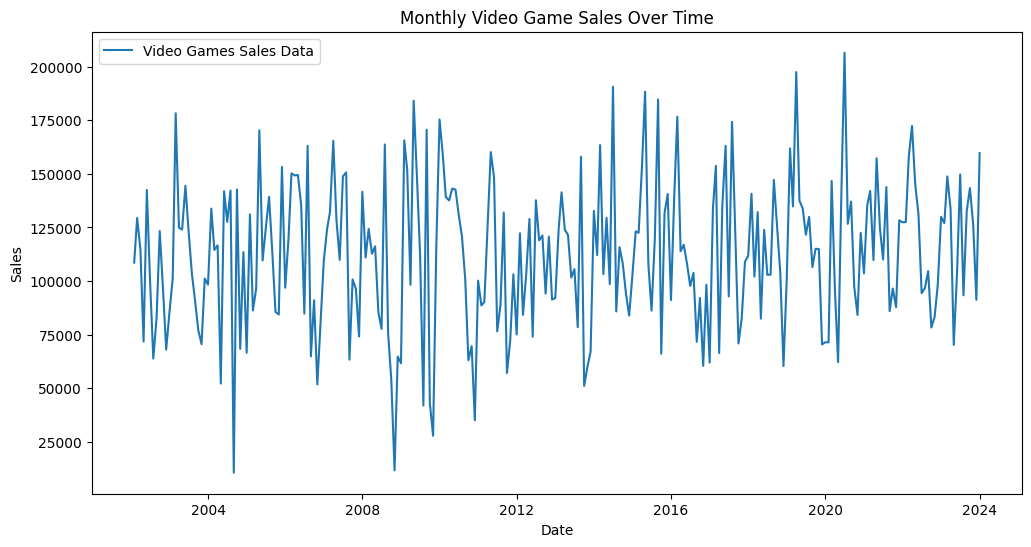

In [11]:
# Plot monthly sales
plt.figure(figsize=(12, 6))
plt.plot(df['Monthly Sales'], label="Video Games Sales Data")
plt.title("Monthly Video Game Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

### Seasonal Patterns in Sales:

This gives an understanding of the overall sales patterns by identifying growth or decline periods in seasons, to help with inventory management and marketing strategies


Firstly Decompose the Time Series

Decompose the time series into trend, seasonality, and residual components.



In [12]:
# Decompose the time series
# Seasonal decomposition
decomposition = seasonal_decompose(df['Monthly Sales'], model='additive', period=12)

<Figure size 1200x600 with 0 Axes>

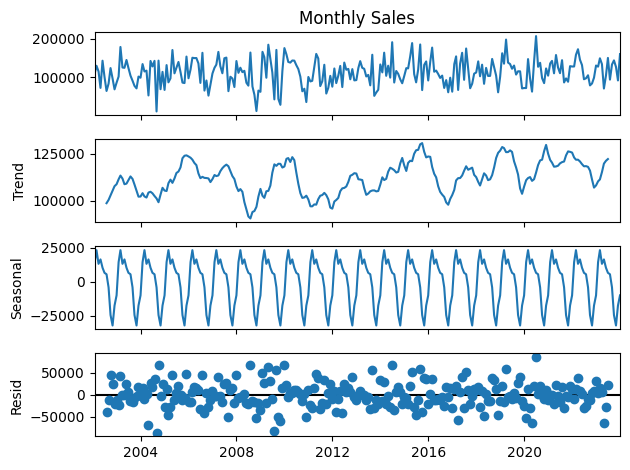

In [13]:
# Plot the decomposition component
plt.figure(figsize=(12, 6))
decomposition.plot()
plt.show()

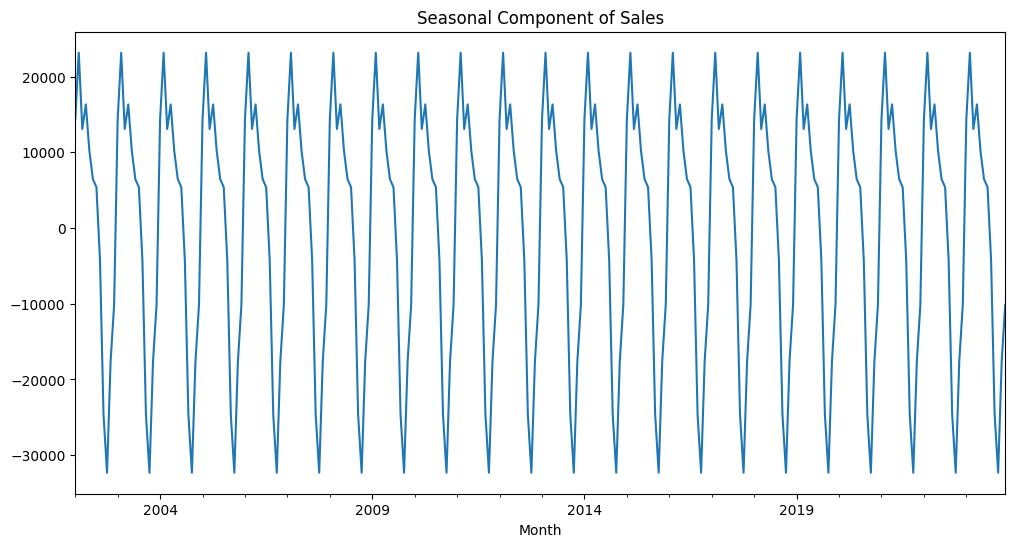

In [14]:
# Plot the seasonal component
plt.figure(figsize=(12, 6))
decomposition.seasonal.plot()
plt.title("Seasonal Component of Sales")
plt.show()

### How Holidays and Promotions relate to the changes in Sales:

This will help with Understanding the influence of holidays and promotions being crucial for marketing planning.

In [15]:
# Compare sales during holidays vs. non-holidays
holiday_sales = df[df['Holiday'] == 1]['Monthly Sales']
non_holiday_sales = df[df['Holiday'] == 0]['Monthly Sales']

# Calculate average sales
average_promotion_sales = round(holiday_sales.mean(), 2)
average_non_promotion_sales = round(non_holiday_sales.mean(), 2)

# Create DataFrame
sales_comparison_df = pd.DataFrame({
    'Condition': ['Holidays', 'Non-holidays'],
    'Average Sales': [average_promotion_sales, average_non_promotion_sales]
})

sales_comparison_df

,Condition,Average Sales
0,Holidays,114933.55
1,Non-holidays,111832.10


      Condition  Average Sales
0      Holidays      114933.55
1  Non-holidays      111832.10


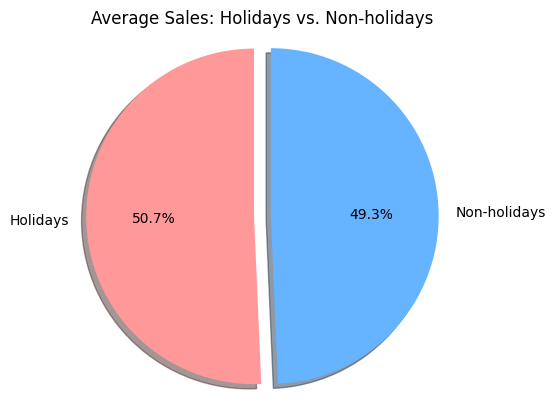

In [16]:
# Display DataFrame
print(sales_comparison_df)

# Create pie chart
labels = sales_comparison_df['Condition']
sizes = sales_comparison_df['Average Sales']
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode the first slice (Holidays)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Average Sales: Holidays vs. Non-holidays')
plt.show()

In [17]:
# Compare sales during promotions vs. non-promotions
promotion_sales = df[df['Promotion'] == 1]['Monthly Sales']
non_promotion_sales = df[df['Promotion'] == 0]['Monthly Sales']

# Calculate average sales
average_promotion_sales = round(promotion_sales.mean(), 2)
average_non_promotion_sales = round(non_promotion_sales.mean(), 2)

# Create DataFrame
promotion_sales_comparison_df = pd.DataFrame({
    'Condition': ['Promotions', 'Non-Promotions'],
    'Average Sales': [average_promotion_sales, average_non_promotion_sales]
})

promotion_sales_comparison_df

,Condition,Average Sales
0,Promotions,113723.30
1,Non-Promotions,111995.61


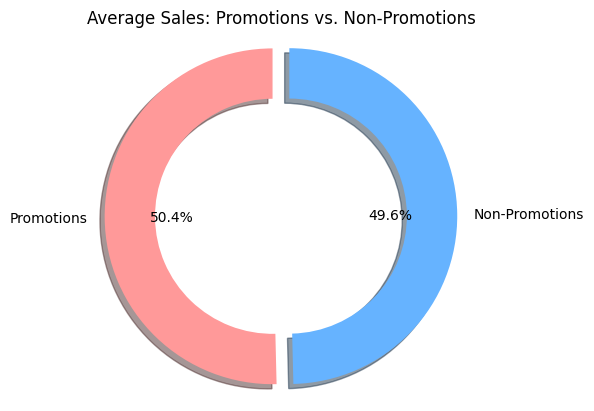

In [18]:
# Create donut plot
labels = promotion_sales_comparison_df['Condition']
sizes = promotion_sales_comparison_df['Average Sales']
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode the first slice (Holidays)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90, wedgeprops=dict(width=0.3))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Average Sales: Promotions vs. Non-Promotions')
plt.show()

### Influence of Sales by the the day of the week:

Identifying the patterns in sales across days of the week to optimize promotional activity.

In [19]:
# Group sales by day of the week
day_of_week_sales = df.groupby('DayOfWeek')['Monthly Sales'].mean()

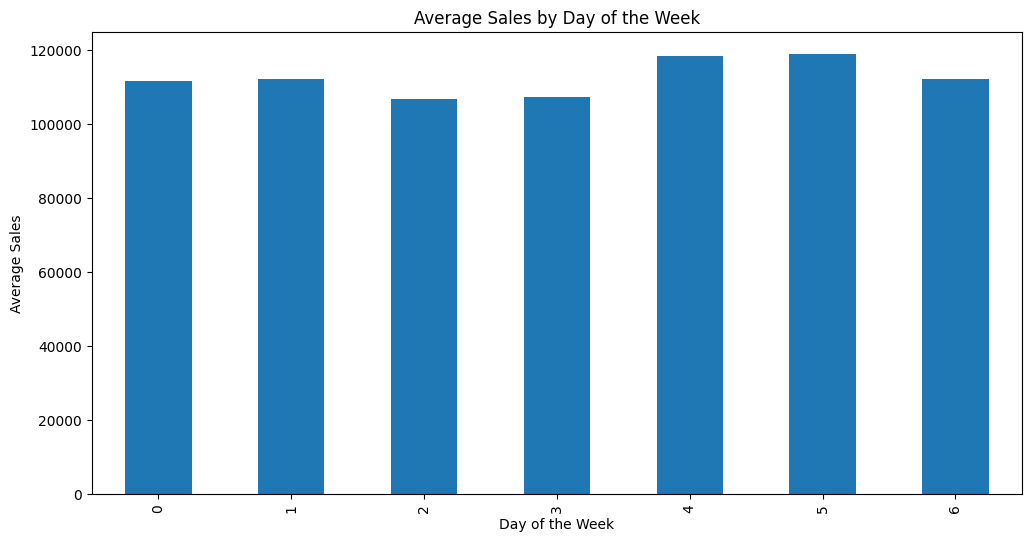

In [20]:
# Plot sales by day of the week
plt.figure(figsize=(12, 6))
day_of_week_sales.plot(kind='bar')
plt.title("Average Sales by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Sales")
plt.show()

### Analysis of Sales Distribution
Checking for the distribution of monthly sales to understand its spread and identify any outliers.

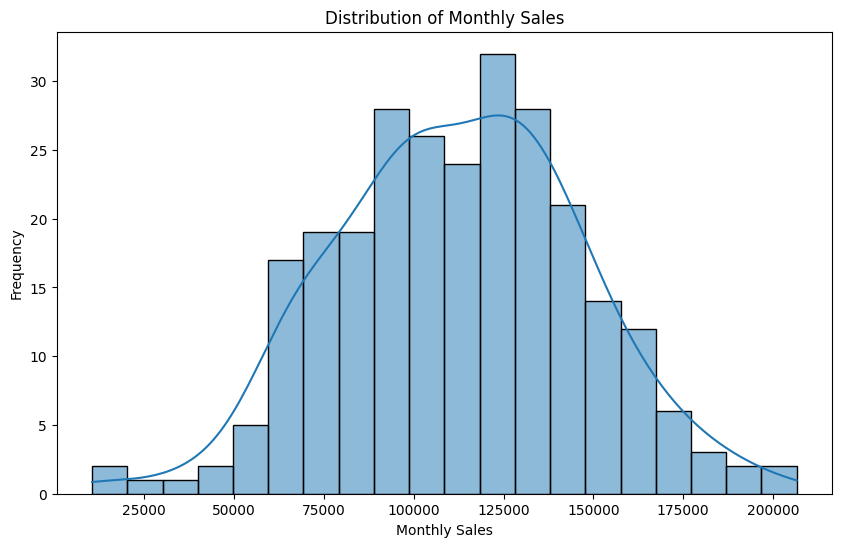

In [21]:
# Plot distribution of monthly sales
plt.figure(figsize=(10, 6))
sns.histplot(df['Monthly Sales'], bins=20, kde=True)
plt.title("Distribution of Monthly Sales")
plt.xlabel("Monthly Sales")
plt.ylabel("Frequency")
plt.show()

###  Sales by Year
Grouping sales by year to see the total and average sales for each year.

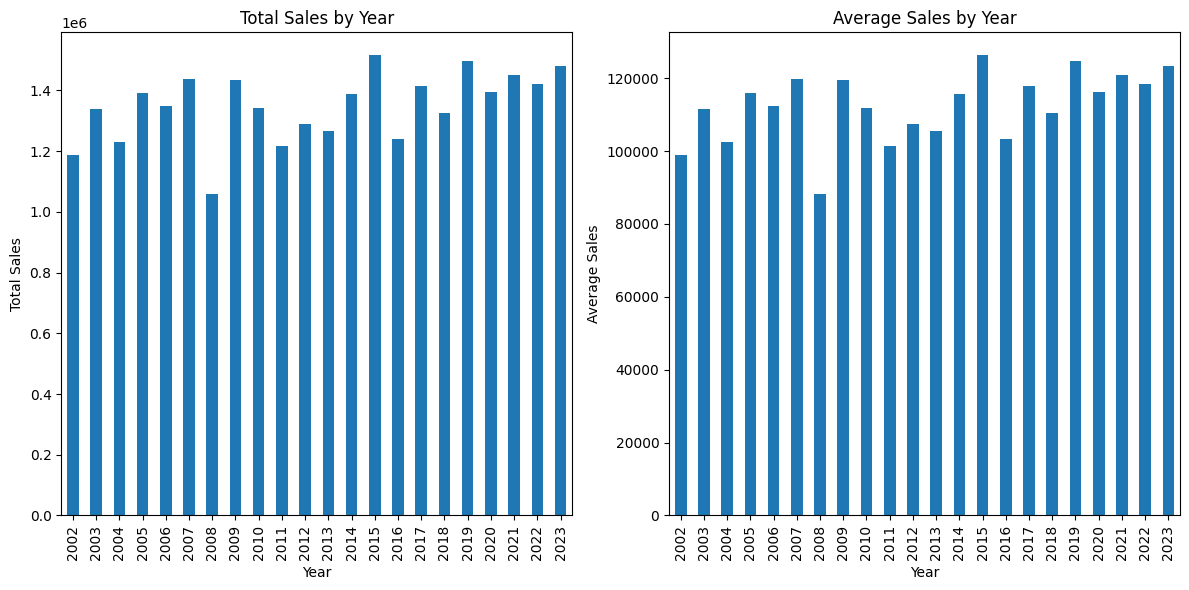

In [22]:
# Group by year and calculate total and average sales
yearly_sales = df.groupby('Year')['Monthly Sales'].agg(['sum', 'mean'])

# Plot yearly sales
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
yearly_sales['sum'].plot(kind='bar')
plt.title("Total Sales by Year")
plt.xlabel("Year")
plt.ylabel("Total Sales")

plt.subplot(1, 2, 2)
yearly_sales['mean'].plot(kind='bar')
plt.title("Average Sales by Year")
plt.xlabel("Year")
plt.ylabel("Average Sales")

plt.tight_layout()
plt.show()

### Sales by Day of the Week
How sales vary across different days of the week.


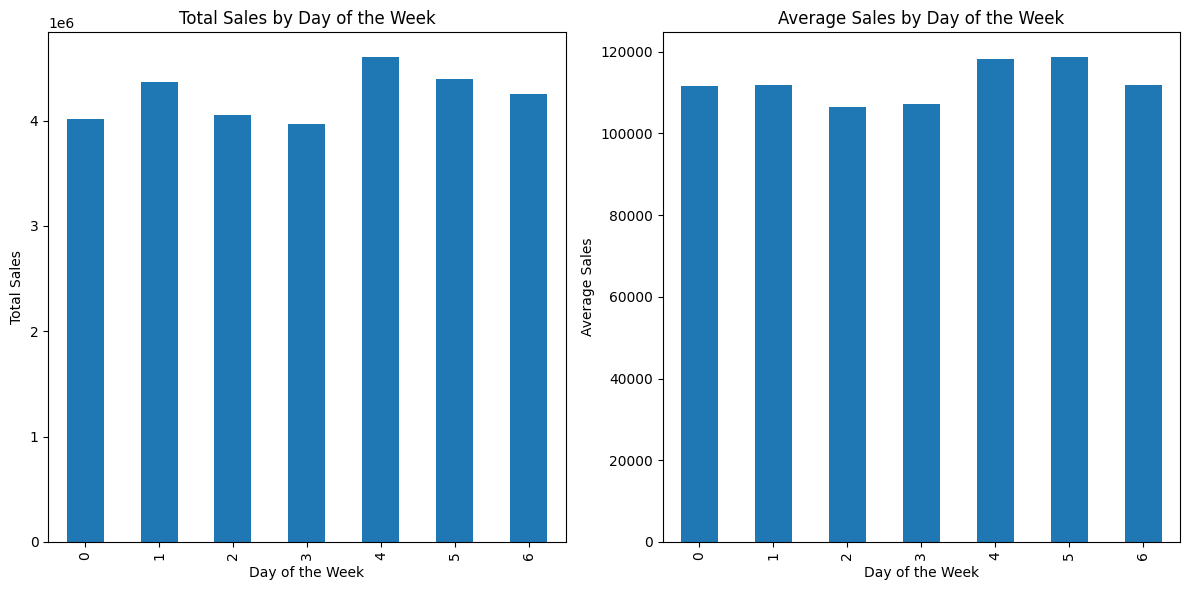

In [25]:
# Group by day of the week and calculate total and average sales
day_of_week_sales = df.groupby('DayOfWeek')['Monthly Sales'].agg(['sum', 'mean'])

# Plot sales by day of the week
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
day_of_week_sales['sum'].plot(kind='bar')
plt.title("Total Sales by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Total Sales")

plt.subplot(1, 2, 2)
day_of_week_sales['mean'].plot(kind='bar')
plt.title("Average Sales by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Sales")

plt.tight_layout()
plt.show()

### Sales During Holidays and Promotions
Analysis of how sales are influenced by holidays and promotions.

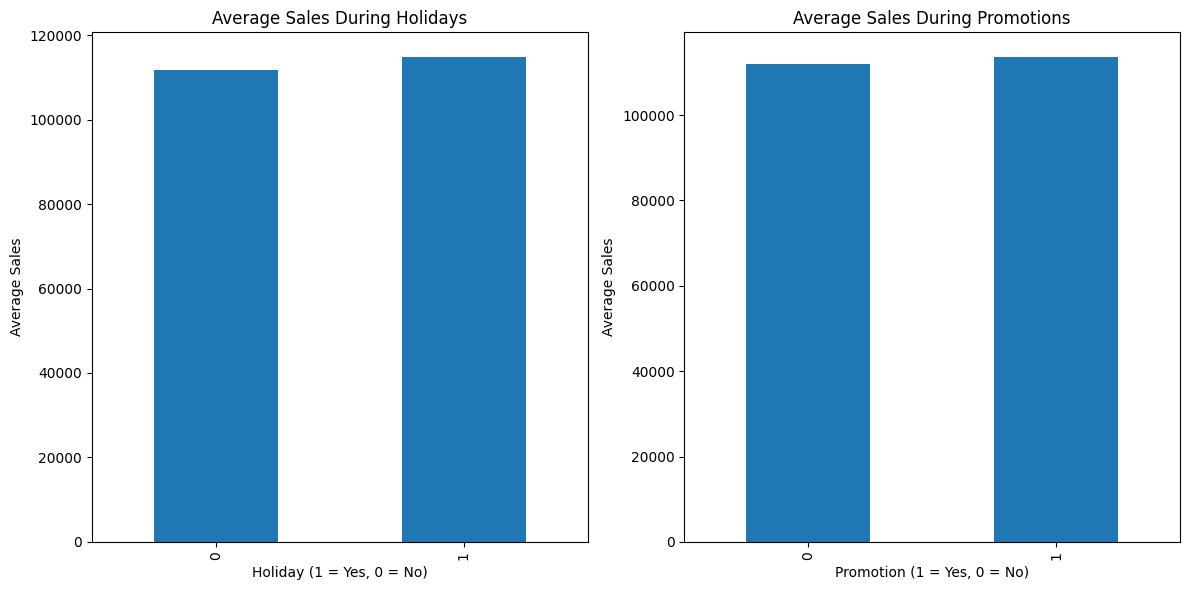

In [26]:
# Group by holiday and calculate total and average sales
holiday_sales = df.groupby('Holiday')['Monthly Sales'].agg(['sum', 'mean'])

# Group by promotion and calculate total and average sales
promotion_sales = df.groupby('Promotion')['Monthly Sales'].agg(['sum', 'mean'])

# Plot sales during holidays and promotions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
holiday_sales['mean'].plot(kind='bar')
plt.title("Average Sales During Holidays")
plt.xlabel("Holiday (1 = Yes, 0 = No)")
plt.ylabel("Average Sales")

plt.subplot(1, 2, 2)
promotion_sales['mean'].plot(kind='bar')
plt.title("Average Sales During Promotions")
plt.xlabel("Promotion (1 = Yes, 0 = No)")
plt.ylabel("Average Sales")

plt.tight_layout()
plt.show()

### Variation of Sales by Category and Platform
Sales variation for different categories across various platforms.

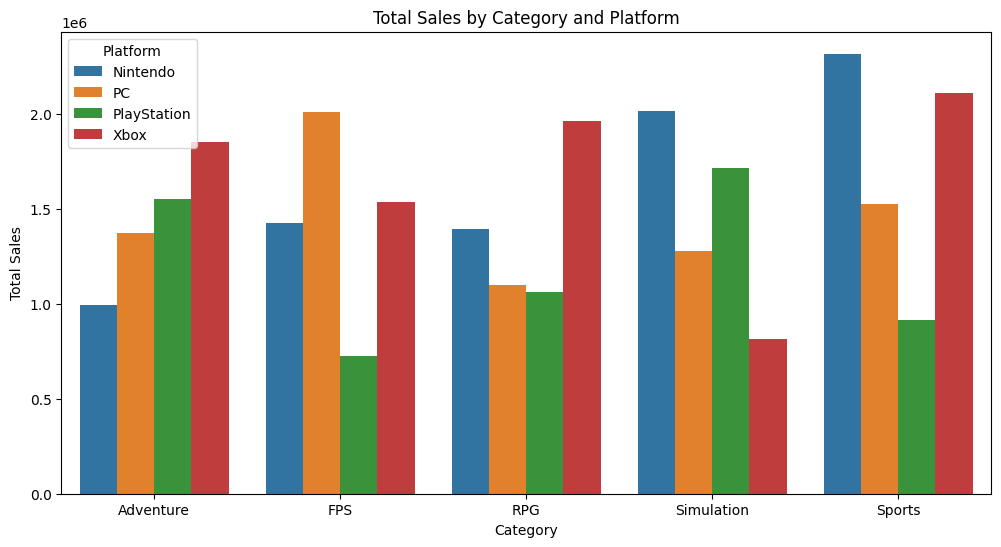

In [32]:
# Group by Category and Platform, and calculate total sales
grouped_df = df.groupby(['Category', 'Platform'])['Monthly Sales'].sum().reset_index()

# Create bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_df, x='Category', y='Monthly Sales', hue='Platform')
plt.title('Total Sales by Category and Platform')
plt.ylabel('Total Sales')
plt.show()

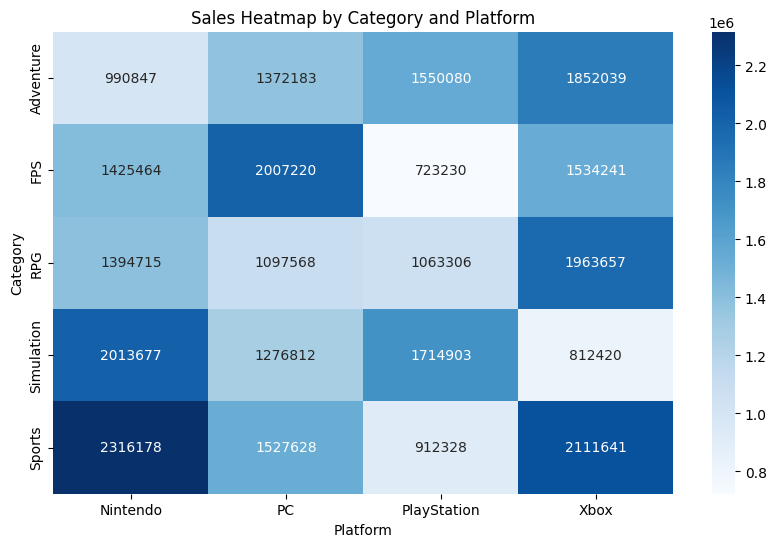

In [31]:
# Create heatmap
pivot_df = grouped_df.pivot(index='Category', columns='Platform', values='Monthly Sales')
# Corrected the usage of pivot with keyword arguments: index, columns, and values.

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, fmt='.0f', cmap='Blues')
plt.title('Sales Heatmap by Category and Platform')
plt.show()

### Prepare the Data for Correlation Analysis

We’ll encode categorical features (e.g., Holiday, Promotion, Season), focus on numerical features for correlation analysis.

In [34]:
df.head()

,Category,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion,YearMonth
Month,,,,,,,,
2002-01-31,Sports,108592,2002,1,Xbox,1,0,2002-01
2002-02-28,RPG,129387,2002,4,Nintendo,0,0,2002-02
2002-03-31,Sports,114777,2002,4,PC,0,0,2002-03
2002-04-30,Sports,71738,2002,0,Nintendo,0,0,2002-04
2002-05-31,Simulation,142512,2002,2,PlayStation,0,0,2002-05


In [36]:
# Encode categorical features
df_encoded = df.copy()
df_encoded['Holiday'] = df_encoded['Holiday'].astype(int)
df_encoded['Promotion'] = df_encoded['Promotion'].astype(int)


# Select all features (numerical + encoded categorical)
all_features = df_encoded[['Category','Monthly Sales', 'Year', 'DayOfWeek', 'Platform', 'Holiday', 'Promotion']]

# Display the first few rows
all_features.head()

,Category,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
Month,,,,,,,
2002-01-31,Sports,108592,2002,1,Xbox,1,0
2002-02-28,RPG,129387,2002,4,Nintendo,0,0
2002-03-31,Sports,114777,2002,4,PC,0,0
2002-04-30,Sports,71738,2002,0,Nintendo,0,0
2002-05-31,Simulation,142512,2002,2,PlayStation,0,0


#### Perform Correlation Analysis
Calculate Correlation Matrix

We’ll calculate the Pearson correlation coefficient between all pairs of features.

This measures the linear relationship between variables.

#### Visualizing the Correlation Matrix
Visualize the correlation matrix using a heatmap for better interpretation

In [40]:
# Encode categorical features
df_encoded = df.copy()
df_encoded['Holiday'] = df_encoded['Holiday'].astype(int)
df_encoded['Promotion'] = df_encoded['Promotion'].astype(int)

# Select all features (numerical + encoded categorical)
all_features = df_encoded[['Category', 'Monthly Sales', 'Year', 'DayOfWeek', 'Platform', 'Holiday', 'Promotion']]

# Perform one-hot encoding for categorical features
all_features = pd.get_dummies(all_features, columns=['Category', 'Platform'], drop_first=True)

# Calculate correlation matrix
correlation_matrix = all_features.corr()

# Display the correlation matrix
correlation_matrix

,Monthly Sales,Year,DayOfWeek,Holiday,Promotion,Category_FPS,Category_RPG,Category_Simulation,Category_Sports,Platform_PC,Platform_PlayStation,Platform_Xbox
Monthly Sales,1.000000,1.346475e-01,0.055444,3.391568e-02,2.044883e-02,0.119054,-0.090241,0.024778,0.063816,0.112890,-0.148287,-0.064936
Year,0.134647,1.000000e+00,0.009144,4.098001e-16,-1.977894e-15,-0.014827,-0.087071,0.126278,-0.072378,-0.000708,0.044702,-0.042197
DayOfWeek,0.055444,9.144262e-03,1.000000,1.786348e-02,2.539948e-02,0.007289,0.035435,-0.012428,0.038032,0.177374,-0.039780,-0.003628
Holiday,0.033916,4.098001e-16,0.017863,1.000000e+00,-5.039526e-02,-0.075281,0.034075,-0.064362,0.028465,0.116547,0.106375,-0.082310
Promotion,0.020449,-1.977894e-15,0.025399,-5.039526e-02,1.000000e+00,0.083129,-0.062249,0.132445,-0.114247,-0.032911,0.048453,-0.073533
Category_FPS,0.119054,-1.482729e-02,0.007289,-7.528096e-02,8.312893e-02,1.000000,-0.230490,-0.227727,-0.249671,0.097259,-0.079537,0.032142
Category_RPG,-0.090241,-8.707138e-02,0.035435,3.407496e-02,-6.224910e-02,-0.230490,1.000000,-0.242342,-0.265695,-0.045533,-0.009759,0.063743
Category_Simulation,0.024778,1.262783e-01,-0.012428,-6.436227e-02,1.324451e-01,-0.227727,-0.242342,1.000000,-0.262509,-0.040610,0.111125,-0.120401
Category_Sports,0.063816,-7.237782e-02,0.038032,2.846493e-02,-1.142475e-01,-0.249671,-0.265695,-0.262509,1.000000,-0.013646,-0.108973,0.020387
Platform_PC,0.112890,-7.082297e-04,0.177374,1.165467e-01,-3.291131e-02,0.097259,-0.045533,-0.040610,-0.013646,1.000000,-0.290869,-0.348534


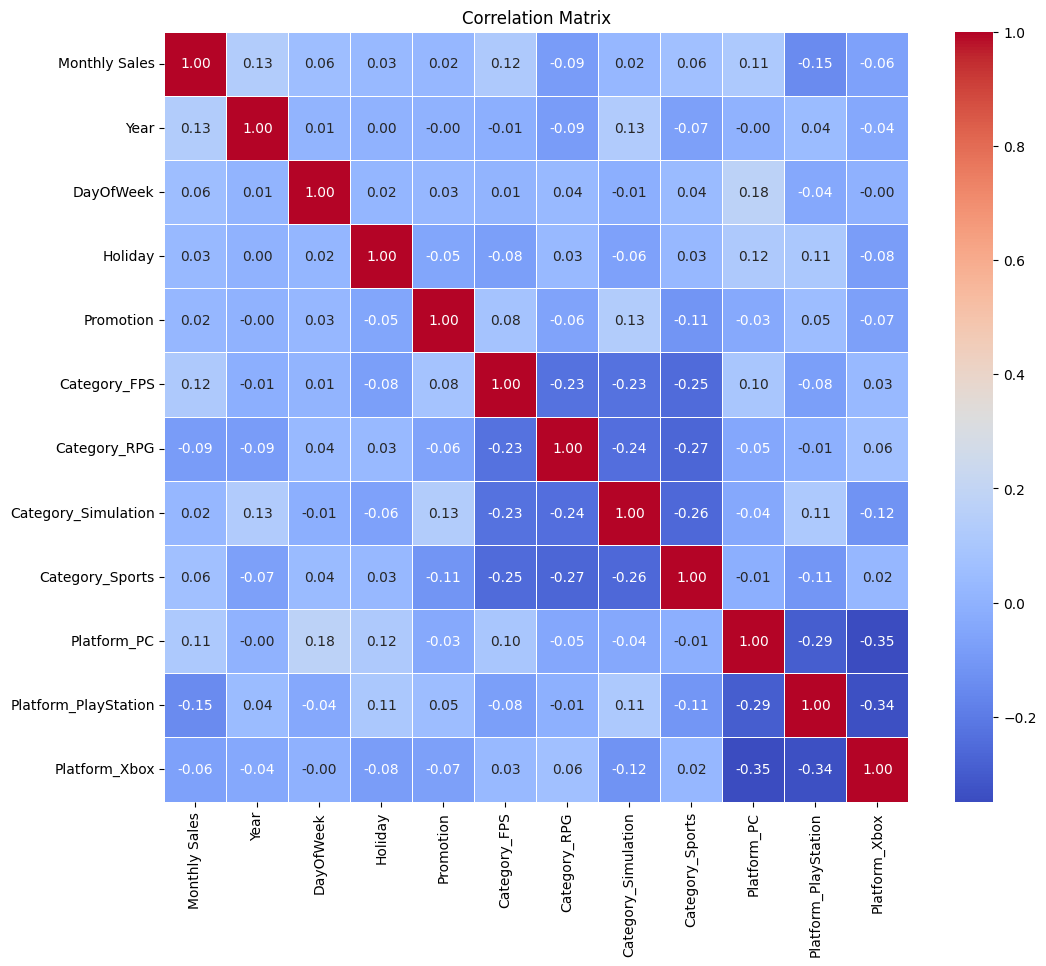

In [41]:
# Plot correlation heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

#### Analysis of Correlations with Monthly Sales
Focusing on the correlation between Monthly Sales and other features.

In [42]:
# Extract correlations with Monthly Sales
sales_correlation = correlation_matrix['Monthly Sales'].sort_values(ascending=False)

# Display correlations
print(sales_correlation)

Monthly Sales           1.000000
Year                    0.134647
Category_FPS            0.119054
Platform_PC             0.112890
Category_Sports         0.063816
DayOfWeek               0.055444
Holiday                 0.033916
Category_Simulation     0.024778
Promotion               0.020449
Platform_Xbox          -0.064936
Category_RPG           -0.090241
Platform_PlayStation   -0.148287
Name: Monthly Sales, dtype: float64


### Key Insights
Note: IF;

`Strong Positive Correlation`: Features with a correlation coefficient close to +1 indicate a strong positive relationship with Monthly Sales.

`Strong Negative Correlation`: Features with a correlation coefficient close to -1 indicate a strong negative relationship with Monthly Sales.

`Weak or No Correlation`: Features with a correlation coefficient close to 0 indicate little to no relationship with Monthly Sales.

Also:

If Promotion has a high positive correlation with Monthly Sales, it means promotions are associated with higher sales.

If DayOfWeek has a low correlation with Monthly Sales, it means the day of the week has little impact on sales.

#### Summary of Findings
Trends: Overall sales trends over time (oscillating).

Seasonality: Strong seasonal patterns in sales (such as, higher sales in certain months ).

Holidays and Promotions: Impact of holidays and promotions on sales.

Day of the Week: Variations in sales across days of the week.
